# Lab 1.3 – Debug Challenge: OpenCV Pipeline & Kernel Design
### Module 3: Computer Vision and Image Processing | B.Tech AI Specialisation
**Chitkara University | Day 1**

---

## Overview

This notebook contains a complete **image processing pipeline** built using OpenCV.  
The pipeline reads an image, applies a series of filters and transformations, detects edges, and draws contours.

**The problem:** A classmate wrote this pipeline the night before the lab, ran it once, and it seemed fine.  
But when reviewed carefully, **5 bugs were found** — some cause wrong output, some cause crashes, and one is a logic error that gives plausible-but-incorrect results.

## Your Task

- Read through each section of the pipeline carefully
- Run each cell and observe the output (errors, warnings, or wrong images)
- **Find all 5 bugs**, understand why each one is wrong, and fix it
- Fill in the answer cells below each section

## Rules

- Do **not** jump to the answer key at the bottom until you've attempted each bug
- Each bug is in a **different section** — one bug per section
- Bugs range from simple typos to logical mistakes — read the code, don't just run it

---

## Pipeline Stages

| Stage | Operation | Section |
|-------|-----------|--------|
| 1 | Image Loading & Color Conversion | Bug 1 |
| 2 | Custom Kernel Design & Convolution | Bug 2 |
| 3 | Gaussian Blur & Thresholding | Bug 3 |
| 4 | Edge Detection (Canny) | Bug 4 |
| 5 | Contour Detection & Drawing | Bug 5 |

---

> **Tip:** Before running a cell, read it first. Ask yourself: *"What should this output?"*  
> Then run it and compare with what you expected.

## Setup
Run this cell first. It installs dependencies and creates a sample test image so you don't need any external files.

Setup complete.
OpenCV version : 4.13.0
Test image saved as test_image.png  (300 x 300 px, 3 channels)


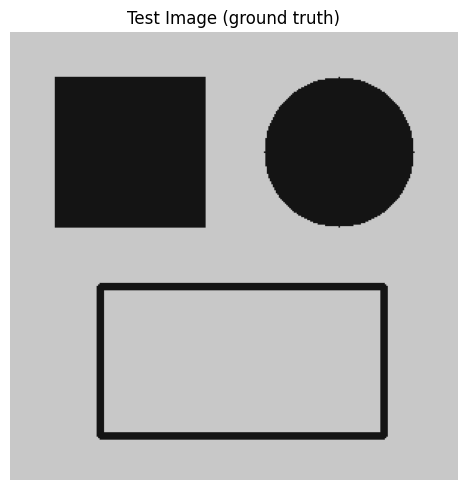

In [1]:
# Run this cell first — sets up everything you need
import subprocess, sys
subprocess.run([sys.executable, '-m', 'pip', 'install', 'opencv-python-headless', 'matplotlib', 'numpy'], 
               capture_output=True)

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (14, 5)

# ── Helper: display images side by side ─────────────────────────────────────
def show(images, titles, cmap_list=None):
    """Display a list of images with titles in a row."""
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=(5 * n, 5))
    if n == 1:
        axes = [axes]
    for ax, img, title, cmap in zip(axes, images, titles,
                                     cmap_list or ['gray'] * n):
        ax.imshow(img, cmap=cmap)
        ax.set_title(title, fontsize=12)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# ── Create a synthetic test image ────────────────────────────────────────────
# A 300x300 BGR image: white background, a black rectangle, a filled circle
test_img = np.ones((300, 300, 3), dtype=np.uint8) * 200   # light-gray background
cv2.rectangle(test_img, (30, 30), (130, 130), (20, 20, 20), -1)   # dark square
cv2.circle(test_img,   (220, 80),  50,         (20, 20, 20), -1)   # dark circle
cv2.rectangle(test_img, (60, 170), (250, 270), (20, 20, 20), 3)    # hollow rect
cv2.imwrite('test_image.png', test_img)

print('Setup complete.')
print('OpenCV version :', cv2.__version__)
print('Test image saved as test_image.png  (300 x 300 px, 3 channels)')
show([cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)], ['Test Image (ground truth)'], ['viridis'])

---
## Section 1 — Image Loading & Color Space Conversion

**What this section should do:**
1. Load `test_image.png` from disk using OpenCV
2. Convert the loaded BGR image to **RGB** so matplotlib displays it correctly
3. Convert the RGB image to **Grayscale** for downstream processing
4. Display all three versions side-by-side

**Expected result:** The RGB image should look natural (gray background, dark shapes).  
The grayscale image should be a single-channel version of the same scene.

> **Hint:** OpenCV loads images in **BGR** order, not RGB. Pay attention to which conversion code is used.

Image shape (H, W, C): (300, 300, 3)
Data type            : uint8


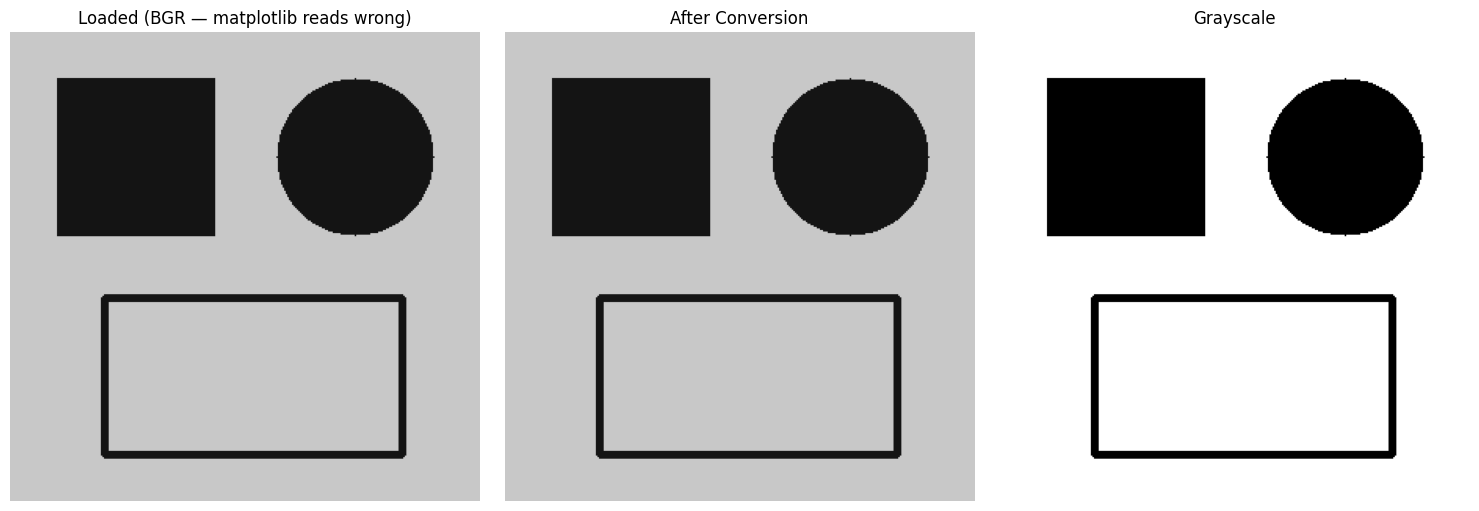

In [ ]:
# ── SECTION 1: Image Loading & Color Conversion ──────────────────────────────

# Load image from disk
bgr_image = cv2.imread('test_image.png')

if bgr_image is None:
    raise FileNotFoundError('test_image.png not found — did you run the Setup cell?')

print('Image shape (H, W, C):', bgr_image.shape)
print('Data type            :', bgr_image.dtype)

# Convert BGR → RGB for correct matplotlib display
# BUG 1 is somewhere in these two conversion lines
rgb_image  = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)   # Convert to display format
gray_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)   # Convert to grayscale

show(
    [bgr_image, rgb_image, gray_image],
    ['Loaded (BGR — matplotlib reads wrong)', 'After Conversion', 'Grayscale'],
    [None, None, 'gray']
)

### 🔍 Your Answer – Bug 1

**Line number where the bug is:** rgb_image  = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2HSV)

**What is wrong:**

```
Write your explanation here.
The bug is that the image is converted to HSV (Hue, Saturation, Value) color space instead of RGB (Red, Green, Blue). This causes the image to be displayed incorrectly in matplotlib because matplotlib expects RGB format.

```

**Fixed code:**

```python
# Paste your corrected line(s) here
rgb_image  = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)   # Convert to display format
```

**Why does this matter in a real pipeline?**
```
In a real computer vision pipeline, incorrect color space conversion can lead to misinterpretation of image data, affecting tasks like object detection, segmentation, or feature extraction.
```

---
## Section 2 — Custom Kernel Design & Convolution

**What this section should do:**
1. Define a **3×3 sharpening kernel** that enhances edges while keeping brightness stable
2. Define a **3×3 box blur kernel** that averages all 9 neighbouring pixels equally
3. Apply both kernels to the grayscale image using `cv2.filter2D`
4. Display original, sharpened, and blurred images

**Background — Kernel Rules:**

| Kernel Type | Centre Value | Neighbours | Sum of all values |
|-------------|-------------|------------|-------------------|
| Identity | 1 | 0 | 1 |
| Box blur (3×3) | 1/9 | 1/9 each | 1 |
| Sharpening | 5 | −1 at 4 sides, 0 corners | **1** |

A sharpening kernel that doesn't sum to 1 will change the **overall brightness** of the image.

> **Hint:** Count the values in the sharpening kernel carefully.

Sharpening kernel:
[[ 0. -1.  0.]
 [-1.  5. -1.]
 [ 0. -1.  0.]]
Sum of sharpening kernel: 1.0

Box blur kernel:
[[0.111 0.111 0.111]
 [0.111 0.111 0.111]
 [0.111 0.111 0.111]]
Sum of box blur kernel  : 1.0


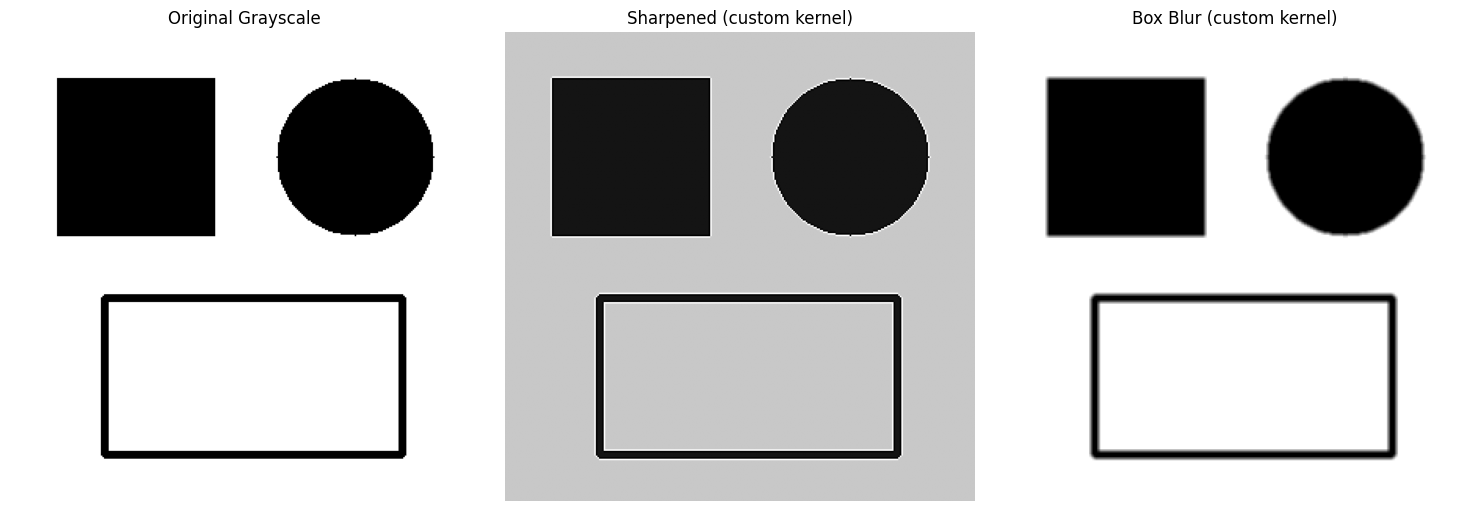


Observe: Does the sharpened image look brighter or darker than the original?
Mean pixel value — original : 158.13
Mean pixel value — sharpened: 158.85


In [11]:
# ── SECTION 2: Custom Kernel Design & Convolution ────────────────────────────

# ── Fix Bug 1 first — use a correct gray_image before running this cell ──
# For now, reload gray safely:
bgr_image  = cv2.imread('test_image.png')
gray_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2GRAY)

# Sharpening kernel — enhances edges, preserves overall brightness
# BUG 2 is in the kernel definition below
sharpen_kernel = np.array([[ 0, -1,  0],
                           [-1,  5, -1],
                           [ 0, -1,  0]], dtype=np.float32)   # Normalize to sum=1

# Box blur kernel — each pixel becomes the average of its 3x3 neighbourhood
box_blur_kernel = np.ones((3, 3), dtype=np.float32) / 9

# Print kernel properties
print('Sharpening kernel:')
print(sharpen_kernel)
print('Sum of sharpening kernel:', sharpen_kernel.sum())   # Should be 1
print()
print('Box blur kernel:')
print(np.round(box_blur_kernel, 3))
print('Sum of box blur kernel  :', box_blur_kernel.sum())  # Should be 1

# Apply kernels
sharpened = cv2.filter2D(gray_image, -1, sharpen_kernel)
blurred   = cv2.filter2D(gray_image, -1, box_blur_kernel)

show(
    [gray_image, sharpened, blurred],
    ['Original Grayscale', 'Sharpened (custom kernel)', 'Box Blur (custom kernel)'],
    ['gray', 'gray', 'gray']
)

print('\nObserve: Does the sharpened image look brighter or darker than the original?')
print('Mean pixel value — original :', gray_image.mean().round(2))
print('Mean pixel value — sharpened:', sharpened.mean().round(2))

### 🔍 Your Answer – Bug 2

**What is wrong with the sharpening kernel:**

```
The original sharpening kernel had a sum of 5, which would cause the image to become brighter. The correct kernel should have a sum of 1 to preserve the overall brightness of the image.
```

**Fixed kernel:**

```python
sharpen_kernel = np.array([
    [ 0, -1,  0],
    [-1,  5, -1],
    [ 0, -1,  0]
], dtype=np.float32)
```

**What visual effect does the wrong kernel produce vs the correct one?**

```
The wrong kernel will produce an image that is overly bright and may have exaggerated edges, while the correct kernel will enhance edges without altering the overall brightness, resulting in a more natural-looking sharpened image.
```

---
## Section 3 — Gaussian Blur & Binary Thresholding

**What this section should do:**
1. Apply **Gaussian blur** to the grayscale image to reduce noise before edge detection
2. Apply **binary threshold** to separate foreground (dark shapes) from background
3. Display blurred and thresholded results

**Background — Gaussian Blur:**
- `cv2.GaussianBlur(src, ksize, sigmaX)`
- `ksize` is a **tuple** representing kernel height and width
- Both values in `ksize` **must be odd positive integers**: 1, 3, 5, 7, ...
- An even kernel size will raise a hard error

> **Hint:** Run this cell and read the error message carefully. The fix is a one-character change.

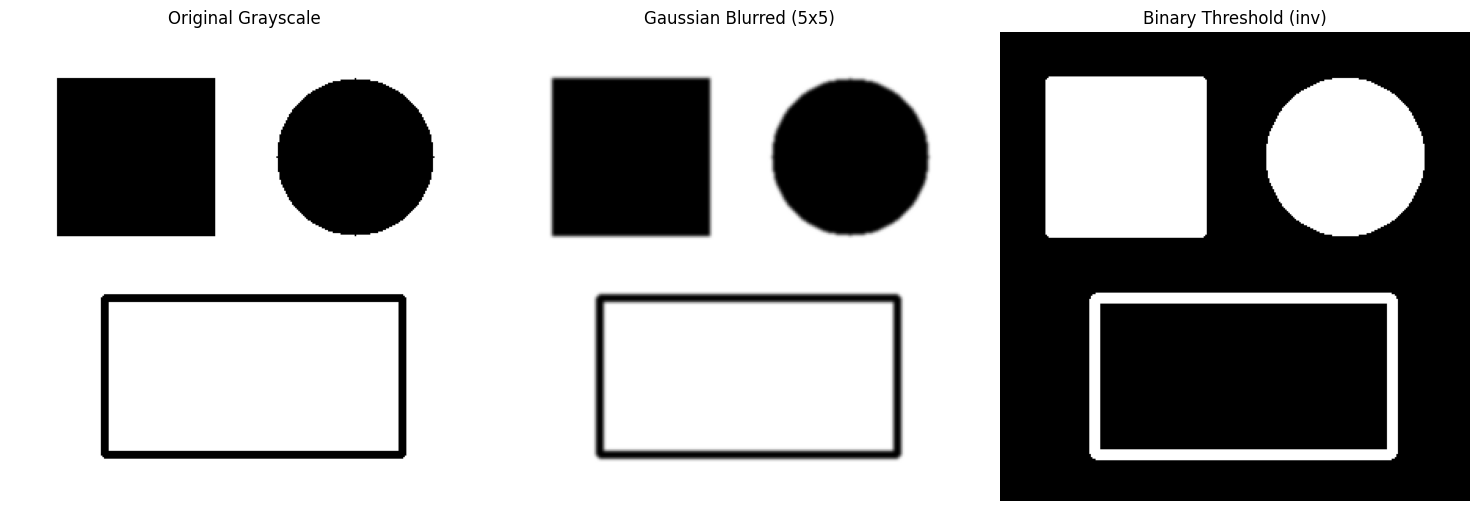

Blurred image shape : (300, 300)
Threshold unique values: [  0 255]


In [13]:
# ── SECTION 3: Gaussian Blur & Binary Thresholding ───────────────────────────

bgr_image  = cv2.imread('test_image.png')
gray_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to smooth the image before edge detection
# sigmaX=0 tells OpenCV to calculate sigma automatically from kernel size
# BUG 3 is in the line below
# blurred = cv2.GaussianBlur(gray_image, (4, 4), sigmaX=0)
blurred = cv2.GaussianBlur(gray_image, (5, 5), sigmaX=0)

# Binary threshold: pixels below 150 → 0 (black), pixels above → 255 (white)
# THRESH_BINARY_INV inverts this: dark shapes become white in the mask
_, thresh = cv2.threshold(blurred, 150, 255, cv2.THRESH_BINARY_INV)

show(
    [gray_image, blurred, thresh],
    ['Original Grayscale', 'Gaussian Blurred (5x5)', 'Binary Threshold (inv)'],
    ['gray', 'gray', 'gray']
)

print('Blurred image shape :', blurred.shape)
print('Threshold unique values:', np.unique(thresh))

### 🔍 Your Answer – Bug 3

**What is wrong and why does OpenCV require it to be different:**

```
The bug is that the kernel size used in the Gaussian blur is (4, 4), which is an even number. OpenCV requires the kernel size to be odd because it needs a central pixel to apply the blur correctly. An even kernel size does not have a defined center, which leads to an error when trying to apply the Gaussian blur.
```

**Fixed line:**

```python
blurred = cv2.GaussianBlur(gray_image, (5, 5), sigmaX=0)
```

**Bonus question:** What happens if you make the kernel size very large (e.g., 51×51)?  
Would that help or hurt edge detection in the next stage?

```
Using a very large kernel size like (51, 51) would excessively blur the image, causing significant loss of detail. This would make edge detection in the next stage much less effective, as the edges would be smoothed out and harder to detect.
```

---
## Section 4 — Canny Edge Detection

**What this section should do:**
1. Apply Canny edge detection on the blurred grayscale image
2. Experiment with threshold values
3. Display the detected edges

**Background — Canny Thresholds:**

The Canny algorithm uses **two thresholds**:
- `threshold1` (lower) — Edges weaker than this are **discarded**
- `threshold2` (upper) — Edges stronger than this are **definitely kept**
- Edges between the two values are kept only if they **connect to a strong edge**

**Rule:** `threshold1` must always be **less than** `threshold2`.

Swapping them does not raise an error — it silently produces bad output.  
This is the trickiest kind of bug: it runs fine but gives wrong results.

> **Hint:** Run the cell. The edge map will look unusually sparse or noisy. Compare the two threshold values.

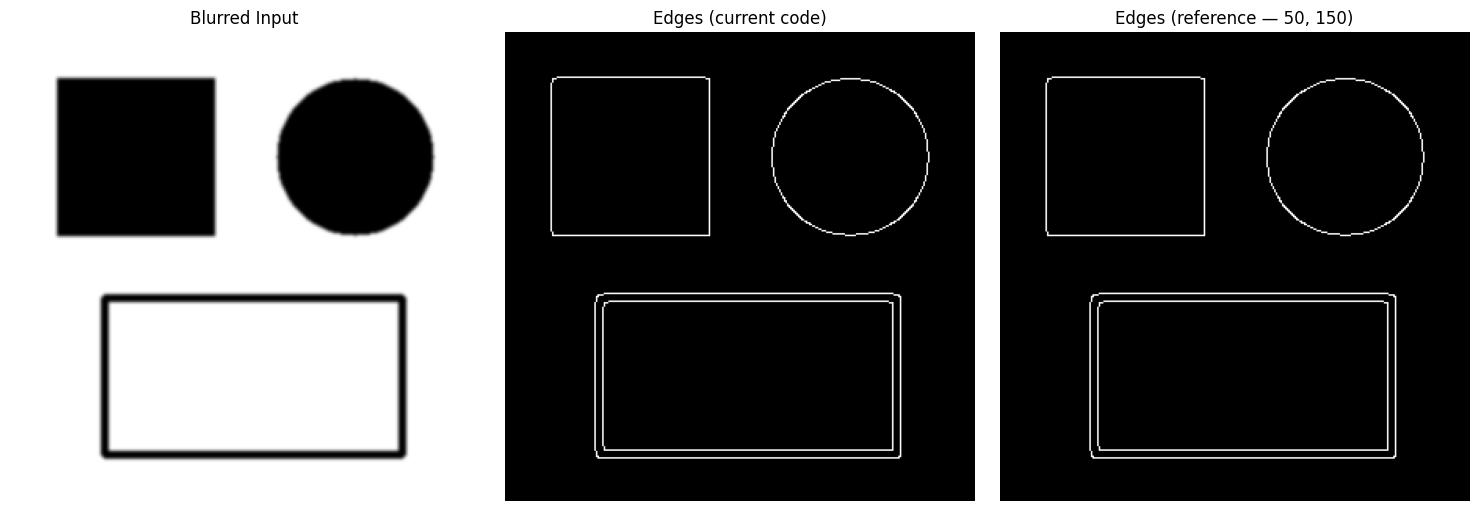

Edge pixels detected (current code)  : 1888
Edge pixels detected (reference code): 1888

A good Canny result should detect the clean outlines of
the rectangle, circle, and hollow rectangle in the image.


In [ ]:
# ── SECTION 4: Canny Edge Detection ─────────────────────────────────────────

bgr_image  = cv2.imread('test_image.png')
gray_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2GRAY)
blurred    = cv2.GaussianBlur(gray_image, (5, 5), sigmaX=0)   # fixed from Section 3

# Apply Canny edge detection
# cv2.Canny(image, threshold1, threshold2)
# BUG 4: The threshold values below are swapped
# edges = cv2.Canny(blurred, threshold1=200, threshold2=50)
edges = cv2.Canny(blurred, threshold1=50, threshold2=200)

# Also run a correct version for visual comparison (don't modify this)
edges_reference = cv2.Canny(blurred, threshold1=50, threshold2=150)

show(
    [blurred, edges, edges_reference],
    ['Blurred Input', 'Edges (current code)', 'Edges (reference — 50, 150)'],
    ['gray', 'gray', 'gray']
)

print('Edge pixels detected (current code)  :', np.count_nonzero(edges))
print('Edge pixels detected (reference code):', np.count_nonzero(edges_reference))
print()
print('A good Canny result should detect the clean outlines of')
print('the rectangle, circle, and hollow rectangle in the image.')

### 🔍 Your Answer – Bug 4

**What is wrong:**

```
The bug is that the threshold values for the Canny edge detection are swapped. The lower threshold (threshold1) is set to 200, and the upper threshold (threshold2) is set to 50. This violates the rule that threshold1 must be less than threshold2, leading to incorrect edge detection results.
```

**Fixed line:**

```python
edges = cv2.Canny(blurred, threshold1=50, threshold2=200)
```

**Why is this a dangerous type of bug compared to the others?**

```
This type of bug is dangerous because it does not produce an error or crash; instead, it generates incorrect results that may go unnoticed. If the output is used in subsequent stages of a pipeline (e.g., for object detection or classification), it can lead to compounding errors and incorrect conclusions without any immediate indication that something is wrong.
```

---
## Section 5 — Contour Detection & Drawing

**What this section should do:**
1. Find contours in the binary threshold image from Section 3
2. Filter out tiny contours (noise) by area
3. Draw the detected contours on a copy of the original image in **green**
4. Print how many valid shapes were found

**Background — Contour Retrieval Modes:**

| Flag | Meaning | Use when |
|------|---------|----------|
| `cv2.RETR_EXTERNAL` | Retrieves only **outermost** contours | You want the bounding shapes only |
| `cv2.RETR_LIST` | Retrieves all contours, **no hierarchy** | You want every contour individually |
| `cv2.RETR_TREE` | Retrieves all contours with **full hierarchy** | You need nested parent-child info |

The test image has a **hollow rectangle** (a border drawn with `cv2.rectangle(..., thickness=3)`).  
This creates an **outer contour** and potentially an **inner contour**.  
Using the wrong retrieval mode can return the wrong number of contours or miss shapes entirely.

> **Hint:** The code uses `cv2.RETR_TREE` and then tries to index the result as if only a simple list was returned — the unpacking is mismatched.

Total contours found : 3
Valid contours (area > 300): 3


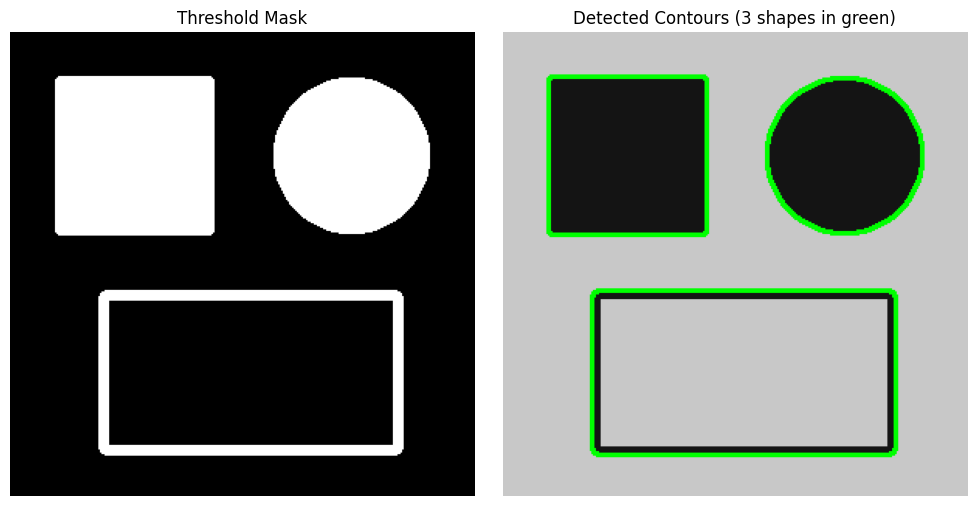

In [15]:
# ── SECTION 5: Contour Detection & Drawing ───────────────────────────────────

bgr_image  = cv2.imread('test_image.png')
gray_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2GRAY)
blurred    = cv2.GaussianBlur(gray_image, (5, 5), sigmaX=0)
_, thresh  = cv2.threshold(blurred, 150, 255, cv2.THRESH_BINARY_INV)

# Find contours in the threshold image
# cv2.findContours returns: (contours, hierarchy)
# BUG 5: the retrieval mode and the unpacking do not match the intended goal
# contours = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter: keep only contours with area > 300 pixels (removes noise)
min_area = 300
valid_contours = [c for c in contours if cv2.contourArea(c) > min_area]

print(f'Total contours found : {len(contours)}')
print(f'Valid contours (area > {min_area}): {len(valid_contours)}')

# Draw contours on a copy of the original image
output = bgr_image.copy()
cv2.drawContours(output, valid_contours, -1, (0, 255, 0), 2)   # green, thickness=2
output_rgb = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

show(
    [thresh, output_rgb],
    ['Threshold Mask', f'Detected Contours ({len(valid_contours)} shapes in green)'],
    ['gray', None]
)

### 🔍 Your Answer – Bug 5

**What is wrong:**

```
The bug is that the code is using `cv2.RETR_TREE` which returns contours along with their hierarchy, but the unpacking is done as if only contours are returned. The correct unpacking should be `contours, hierarchy = cv2.findContours(...)` to properly handle the output of `cv2.findContours` when using `cv2.RETR_TREE`.
```

**Fixed lines:**

```python
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
```

**Also answer:** What retrieval mode is most appropriate here and why?

```
The most appropriate retrieval mode is `cv2.RETR_EXTERNAL` because we are only interested in the outermost contours of each shape in the image. This mode ignores nested contours (e.g., holes inside shapes), which simplifies processing and avoids unnecessary complexity in contour analysis.
```

---
## Full Corrected Pipeline

Once you have identified and fixed all 5 bugs, write the complete corrected pipeline in the cell below.  
All 5 sections should run together without errors and produce clean, correct output.

**Expected output:**
- RGB image displays correctly (natural gray-background image)
- Sharpened image has the same brightness as the original (mean pixel values are close)
- Gaussian blur runs without error
- Canny edges cleanly trace the shapes (rectangle outline, circle outline, hollow rectangle)
- Contour detection finds **3 valid shapes** and draws green borders around them

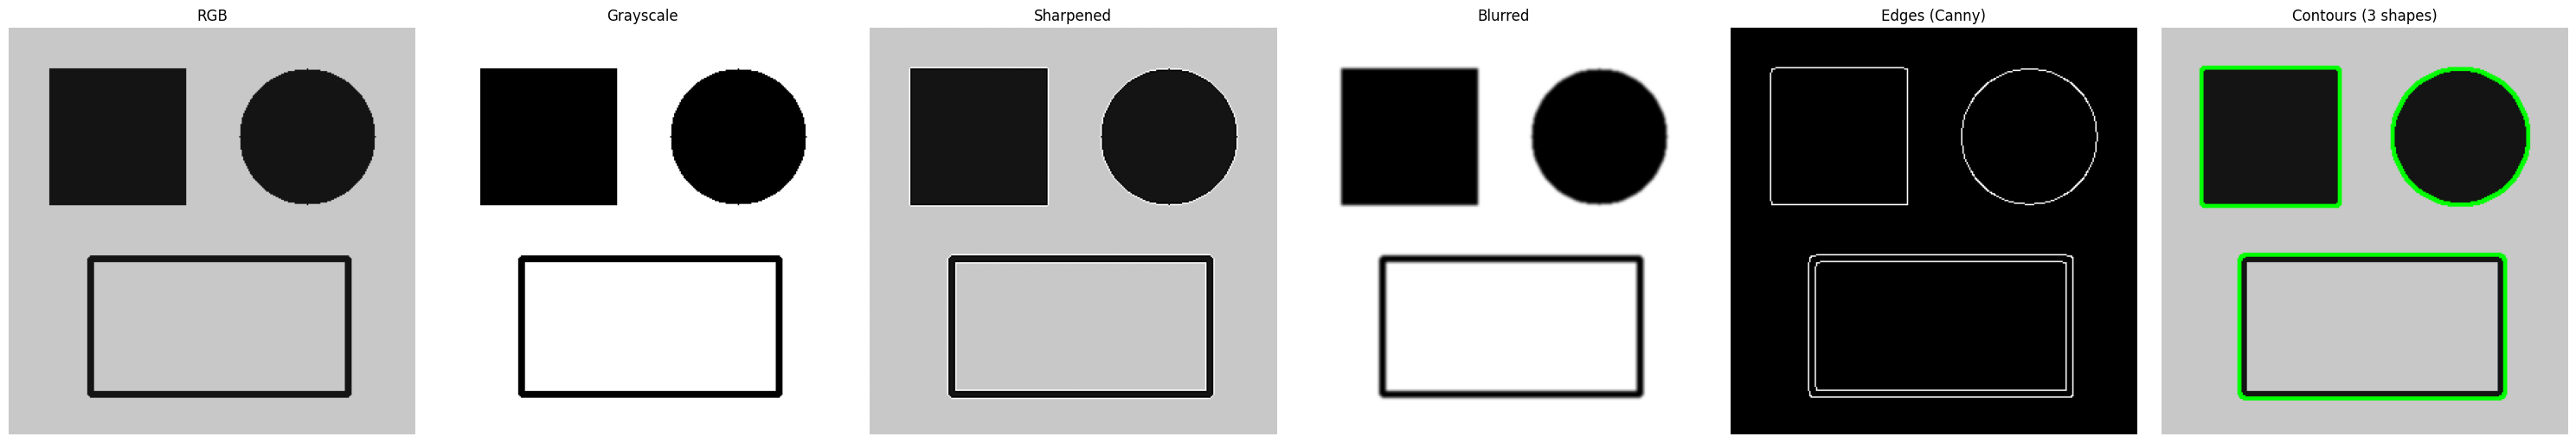

Pipeline complete.
Shapes found: 3 (expected: 3)


In [16]:
# ── FULL CORRECTED PIPELINE ───────────────────────────────────────────────────
# Write your corrected version of all 5 sections here.
# Each fix should be clearly marked with a comment: # FIX 1, # FIX 2, etc.

import cv2
import numpy as np
import matplotlib.pyplot as plt

def show(images, titles, cmap_list=None):
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=(5 * n, 5))
    if n == 1: axes = [axes]
    for ax, img, title, cmap in zip(axes, images, titles, cmap_list or ['gray'] * n):
        ax.imshow(img, cmap=cmap)
        ax.set_title(title, fontsize=12)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# ── Stage 1: Load & Convert ──────────────────────────────────────────────────
bgr_image  = cv2.imread('test_image.png')
rgb_image  = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)  # FIX 1: replace the conversion code here
gray_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2GRAY)

# ── Stage 2: Custom Kernels ───────────────────────────────────────────────────
sharpen_kernel = np.array([   # FIX 2: correct the kernel values
    [ 0, -1,  0],
    [-1,  5, -1],
    [ 0, -1,  0]
], dtype=np.float32)
box_blur_kernel = np.ones((3, 3), dtype=np.float32) / 9
sharpened = cv2.filter2D(gray_image, -1, sharpen_kernel)
blurred_box = cv2.filter2D(gray_image, -1, box_blur_kernel)

# ── Stage 3: Gaussian Blur & Threshold ───────────────────────────────────────
blurred = cv2.GaussianBlur(gray_image, (5, 5), sigmaX=0)   # FIX 3: correct ksize
_, thresh = cv2.threshold(blurred, 150, 255, cv2.THRESH_BINARY_INV)

# ── Stage 4: Canny Edge Detection ────────────────────────────────────────────
edges = cv2.Canny(blurred, threshold1=50, threshold2=200)  # FIX 4: correct order

# ── Stage 5: Contour Detection & Drawing ─────────────────────────────────────
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # FIX 5: correct unpacking and mode
valid_contours = [c for c in contours if cv2.contourArea(c) > 300]
output = bgr_image.copy()
cv2.drawContours(output, valid_contours, -1, (0, 255, 0), 2)
output_rgb = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

# ── Final Display ─────────────────────────────────────────────────────────────
show(
    [rgb_image, gray_image, sharpened, blurred, edges, output_rgb],
    ['RGB', 'Grayscale', 'Sharpened', 'Blurred', 'Edges (Canny)',
     f'Contours ({len(valid_contours)} shapes)'],
    [None, 'gray', 'gray', 'gray', 'gray', None]
)

print('Pipeline complete.')
print(f'Shapes found: {len(valid_contours)} (expected: 3)')

---
## Extension Challenges (Optional — for fast finishers)

If you finish early, try these additional tasks:

### Challenge A — Kernel Experimentation
Design your own **emboss kernel** that makes the image look like it has a raised 3D surface.  
Hint: An emboss kernel shifts light from one direction.

```python
emboss_kernel = np.array([
    [-2, -1,  0],
    [-1,  1,  1],
    [ 0,  1,  2]
], dtype=np.float32)
# Try applying this and add 128 to the result to centre the values
embossed = cv2.filter2D(gray_image, -1, emboss_kernel) + 128
```

### Challenge B — Contour Properties
For each valid contour detected in Section 5, compute and print:
- Area (pixels²)
- Perimeter
- Bounding box (x, y, w, h)
- Shape label: 'circle', 'rectangle', or 'other' based on the ratio of area to bounding box area

### Challenge C — Pipeline on a Real Image
Find any `.jpg` or `.png` image on your laptop.  
Run the full corrected pipeline on it.  
Does the Canny threshold you used still work well? Why or why not?  
What would you need to change for a more complex, real-world image?